# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">Key Points </p>

### 1. Data Distribution
- The dataset was imbalanced in terms of class labels (e.g., depression, suicidal expressions), as revealed by the value counts and pie plot.
- This suggests that care must be taken during model training, possibly through techniques like resampling or class weighting to ensure balanced learning.

### 2. Feature Engineering
- A new feature, **sentence length**, was added to capture the difference between short and long expressions, which could be correlated with specific types of sentiment or emotions (e.g., longer texts containing depressive or suicidal expressions).
- One-hot encoding or label encoding transformed categorical features into a machine-readable form, an essential step in handling the text data.

### 3. Text Preprocessing
- **Lowercasing** ensured consistency in the text, eliminating case-based variations.
- **Special character removal** cleaned up unnecessary noise like URLs, handles, and punctuation, which don’t contribute to the text’s meaning.
- **Tokenization** broke the text into individual words, which is a core step in text processing.
- **Stemming** was applied to reduce words to their root forms, thereby reducing dimensionality and ensuring that variations of the same word (e.g., "running" and "run") are treated as the same during model training.

### 4. Word Cloud
- The word cloud provided a visual representation of the most frequent terms in the data, offering insights into the prominent words associated with depression or suicidal tendencies.
- This visualization was important in understanding the underlying patterns in the text data.

### 5. Resampling
- Resampling was likely used to address class imbalance issues, either through undersampling the majority class or oversampling the minority class, helping the model learn patterns from both classes effectively.

### 6. TF-IDF Vectorizer
- By transforming the text data into numerical features using **TF-IDF**, the most important words in each document were highlighted based on their relevance within the corpus.
- This reduced the impact of common words (stopwords) and emphasized unique terms.


# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#1. Importing Packages </p>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline

import re
import random
from imblearn.over_sampling import RandomOverSampler
from scipy.sparse import hstack  # To combine sparse matrices
from wordcloud import WordCloud

import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib as j

import warnings
warnings.filterwarnings("ignore")

In [2]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv


# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#2. Read Data</p>

In [3]:
df = pd.read_csv("/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv", index_col = 0)
df.sample(5)

,statement,status
25004,"I am depressed like you, but if there is somet...",Depression
4237,"Le ngancani when it's hard to be sopo, how com...",Normal
45333,why isn t the hill available online yet soo di...,Normal
35833,Has anyone successfully learned to accept the ...,Anxiety
6571,â—‹ Full name : Ayana Shahabâ—‹ Nickname : Aya...,Normal


In [4]:
df.shape

(53043, 2)

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#2.1 Removing NULL data </p>

In [5]:
df.isnull().sum()

statement    362
status         0
dtype: int64

In [6]:
# Calculate the length of each statement
df['num_of_characters'] = df['statement'].str.len()

# Display basic statistics of statement lengths
print(df['num_of_characters'].describe())

count    52681.000000
mean       578.713863
std        846.269078
min          2.000000
25%         80.000000
50%        317.000000
75%        752.000000
max      32759.000000
Name: num_of_characters, dtype: float64


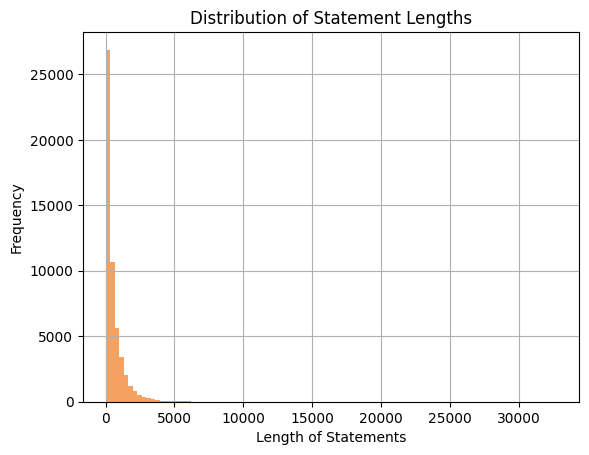

In [7]:
# Plot the distribution of statement lengths
df['num_of_characters'].hist(bins=100, color='#F4A261')
plt.title('Distribution of Statement Lengths')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

> very small amount of data is missing as compare to original data

> so we can remove null data

In [8]:
df.dropna(inplace = True)
df.isna().sum()

statement            0
status               0
num_of_characters    0
dtype: int64

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#2.2 Features Value Count </p>

In [9]:
df['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

<Axes: title={'center': 'Distribution of Sentiments'}, xlabel='status'>

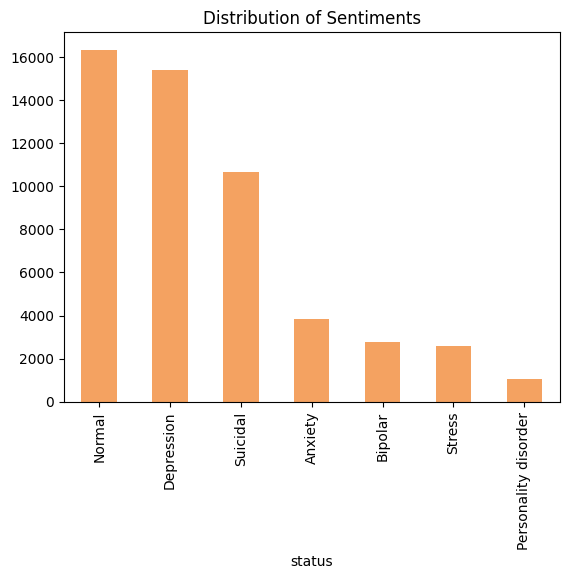

In [10]:
sentiment_counts=df['status'].value_counts()
sentiment_counts.plot(kind='bar', title='Distribution of Sentiments', color='#F4A261')

> we can do hot coding too

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#2.3 Distribution of data</p>

In [11]:
 #us get a more clear picture of this column excluding the outliers

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df['num_of_characters'].quantile(0.25)
Q3 = df['num_of_characters'].quantile(0.75)
IQR = Q3 - Q1

# Define the lower and upper bound for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

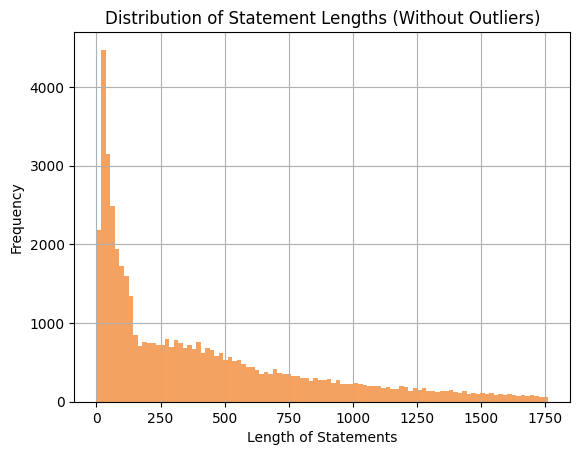

In [12]:
# Filter out the outliers
filtered_df = df[(df['num_of_characters'] >= lower_bound) & (df['num_of_characters'] <= upper_bound)]
# Plot the distribution of statement lengths without outliers
filtered_df['num_of_characters'].hist(bins=100, color='#F4A261')
plt.title('Distribution of Statement Lengths (Without Outliers)')
plt.xlabel('Length of Statements')
plt.ylabel('Frequency')
plt.show()

In [13]:
fig = px.pie(df, names='status',labels='status', title='Mental Health')
fig.show()

In [14]:
df.describe()

,num_of_characters
count,52681.000000
mean,578.713863
std,846.269078
min,2.000000
25%,80.000000
50%,317.000000
75%,752.000000
max,32759.000000


# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3. Text Preprocessing </p>

> Add str len as a featrue

In [15]:
# Calculate the number of characters and sentences
df['num_of_sentences'] = df['statement'].apply(lambda x: len(nltk.sent_tokenize(x)))

In [16]:
# Generate descriptive statistics
df[['num_of_characters', 'num_of_sentences']].describe()

,num_of_characters,num_of_sentences
count,52681.000000,52681.000000
mean,578.713863,6.277728
std,846.269078,10.686230
min,2.000000,1.000000
25%,80.000000,1.000000
50%,317.000000,3.000000
75%,752.000000,8.000000
max,32759.000000,1260.000000


> cz some sentenses are too long

In [17]:
df[df['num_of_characters'] > 10000]

,statement,status,num_of_characters,num_of_sentences
7851,So introduction I guess.. my name is Michael a...,Depression,10679.0,136
9416,AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAA...,Suicidal,25302.0,1
9504,"Hello everyone,I rarely post on Reddit but.......",Depression,11163.0,139
10834,I have only 1 person I can somewhat open to bu...,Suicidal,27390.0,237
11537,"The title is not meant to discourage others, b...",Depression,12304.0,155
11581,I no longer know what else to do but write thi...,Depression,13530.0,140
11636,And has life gotten better?&amp;#x200B;No. Eve...,Depression,12819.0,96
11831,Sorry this is long but I doubt anyone will eve...,Depression,11122.0,155
13293,I cannot TAKE IT ANYMORE. I cannot TAKE IT ANY...,Suicidal,32759.0,1260
18215,I am someone living in Turkey. My age is proba...,Suicidal,10219.0,180


> and most of these containing depression and suicidal expressions 

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.1 RAW data</p>

In [18]:
# Group by status and get a random statement from each group
random_statements = df.groupby('status')['statement'].apply(lambda x: x.sample(n=1).iloc[0])

# Print the results
for status, statement in random_statements.items():
    print(f"Status: {status}")
    print(f"Statement: {statement}\n")

Status: Anxiety
Statement: Recurring chest pain for around a month So I started having pain on the left side of my chest on the inner part of my pec towards the top. It happens mainly when I exhale. Kind of a sharp pain. It sometimes happens on the tail end of taking a deep breath. Movement doesn't increase it. The pain hasn't increased. It's possible that the frequency at which it happens has. I had an appoint two weeks ago and had an ekg and blood tests which neither of which showed abnormalities. Im a 29 y/o male who has exercised on and off for most of my life. Only problem I have is decently high cholesterol. I called the doctor today and they made a referral to a cardiologist on Apr 21. I want to think that's to much I hope. My first worry goes to endocarditis.☹️. Other than that I don't know what to think of it. It's hard not to worry about it. I want to assume its inflammation but I've never experienced something this consistent for so long.

Status: Bipolar
Statement: Thankful

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.2 Lower casing</p>

In [19]:
df['statement']=df['statement'].str.lower()
df.sample(5)

,statement,status,num_of_characters,num_of_sentences
8394,idk even know why the fuck i am typing this i ...,Suicidal,847.0,1
43434,and so the editing of 000 wedding shot begin,Normal,44.0,1
38129,i think the pandemic hit me hard i moved out o...,Depression,1392.0,1
35761,worried about cancer please help! my anxiety i...,Anxiety,290.0,7
31140,i hope god didn't hear that.,Normal,28.0,1


## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.3 Removing unnecessary punctuations and URL</p>

> Removing URLs, handles, punctuation and special characters

In [20]:
def remove_patterns(text):
    # Remove URLs
    text = re.sub(r'http[s]?://\S+', '', text)
    # Remove markdown-style links
    text = re.sub(r'\[.*?\]\(.*?\)', '', text)
    # Remove handles (that start with '@')
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and other special characters
    text = re.sub(r'[^\w\s]', '', text)
    return text.strip()

# Apply the function to the 'statement' column
df['statement'] = df['statement'].apply(remove_patterns)
df.sample(5)

,statement,status,num_of_characters,num_of_sentences
36818,i do not want all this,Normal,23.0,1
26919,if i overdose on heroine you guys will going t...,Depression,90.0,1
35213,3 weeks of crazy medical symptoms and scared o...,Anxiety,3552.0,47
47481,how i feel this will probably go unseen but i ...,Depression,865.0,16
30540,i like the kinds of instruments that they use,Normal,46.0,1


## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.4 Tokenization</p>

> Split text into individual words or token

In [21]:
# Apply word_tokenize to each element in the 'statement' column
df['tokens'] = df['statement'].apply(word_tokenize)
df.sample(5)

,statement,status,num_of_characters,num_of_sentences,tokens
3093,i want to watch come with me,Normal,30.0,1,"[i, want, to, watch, come, with, me]"
50400,ive had a rough week this is literally just m...,Bipolar,2252.0,7,"[ive, had, a, rough, week, this, is, literally..."
50807,feeling disconnected from peers how do i stan...,Personality disorder,1513.0,15,"[feeling, disconnected, from, peers, how, do, ..."
1605,break dance dos jumil no rtk,Normal,30.0,1,"[break, dance, dos, jumil, no, rtk]"
1301,hi buddy,Normal,9.0,2,"[hi, buddy]"


## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.5 Stemming</p> 

Stemming is a more aggressive process than lemmatization, which also reduces words to their base form but takes into account the word's meaning and grammar.

In DL applications, stemming can be useful in:

> Text classification: Simplifies the vocabulary, reducing dimensionality.

> Sentiment analysis: Helps capture similar sentiments across different word forms.

> Topic modeling: Groups words with similar meanings.

In [22]:
# Initialize the stemmer
stemmer = PorterStemmer()

# Function to stem tokens and convert them to strings
def stem_tokens(tokens):
    return ' '.join(stemmer.stem(str(token)) for token in tokens)

# Apply the function to the 'tokens' column
df['tokens_stemmed'] = df['tokens'].apply(stem_tokens)

df.sample(5)

,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed
10139,you ever get that feeling of either complete n...,Depression,777.0,3,"[you, ever, get, that, feeling, of, either, co...",you ever get that feel of either complet numb ...
19068,in last two years of school i was hopeless and...,Depression,379.0,5,"[in, last, two, years, of, school, i, was, hop...",in last two year of school i wa hopeless and d...
21757,probably not the best place to look for help b...,Depression,1312.0,21,"[probably, not, the, best, place, to, look, fo...",probabl not the best place to look for help bu...
17241,i attempted in march of this year i overdosed ...,Suicidal,921.0,11,"[i, attempted, in, march, of, this, year, i, o...",i attempt in march of thi year i overdos but p...
29625,i never searched for a man to make me happy or...,Normal,389.0,5,"[i, never, searched, for, a, man, to, make, me...",i never search for a man to make me happi or b...


## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#3.6 Word Clouds</p>

In [23]:
colors = ['#16325B', '#227B94', '#78B7D0', '#FFDC7F', '#18587A', '#11999E', '#283644']

# Define a color function
def color_func(word, font_size, position, orientation, random_state=101, **kwargs):
    return random.choice(colors)

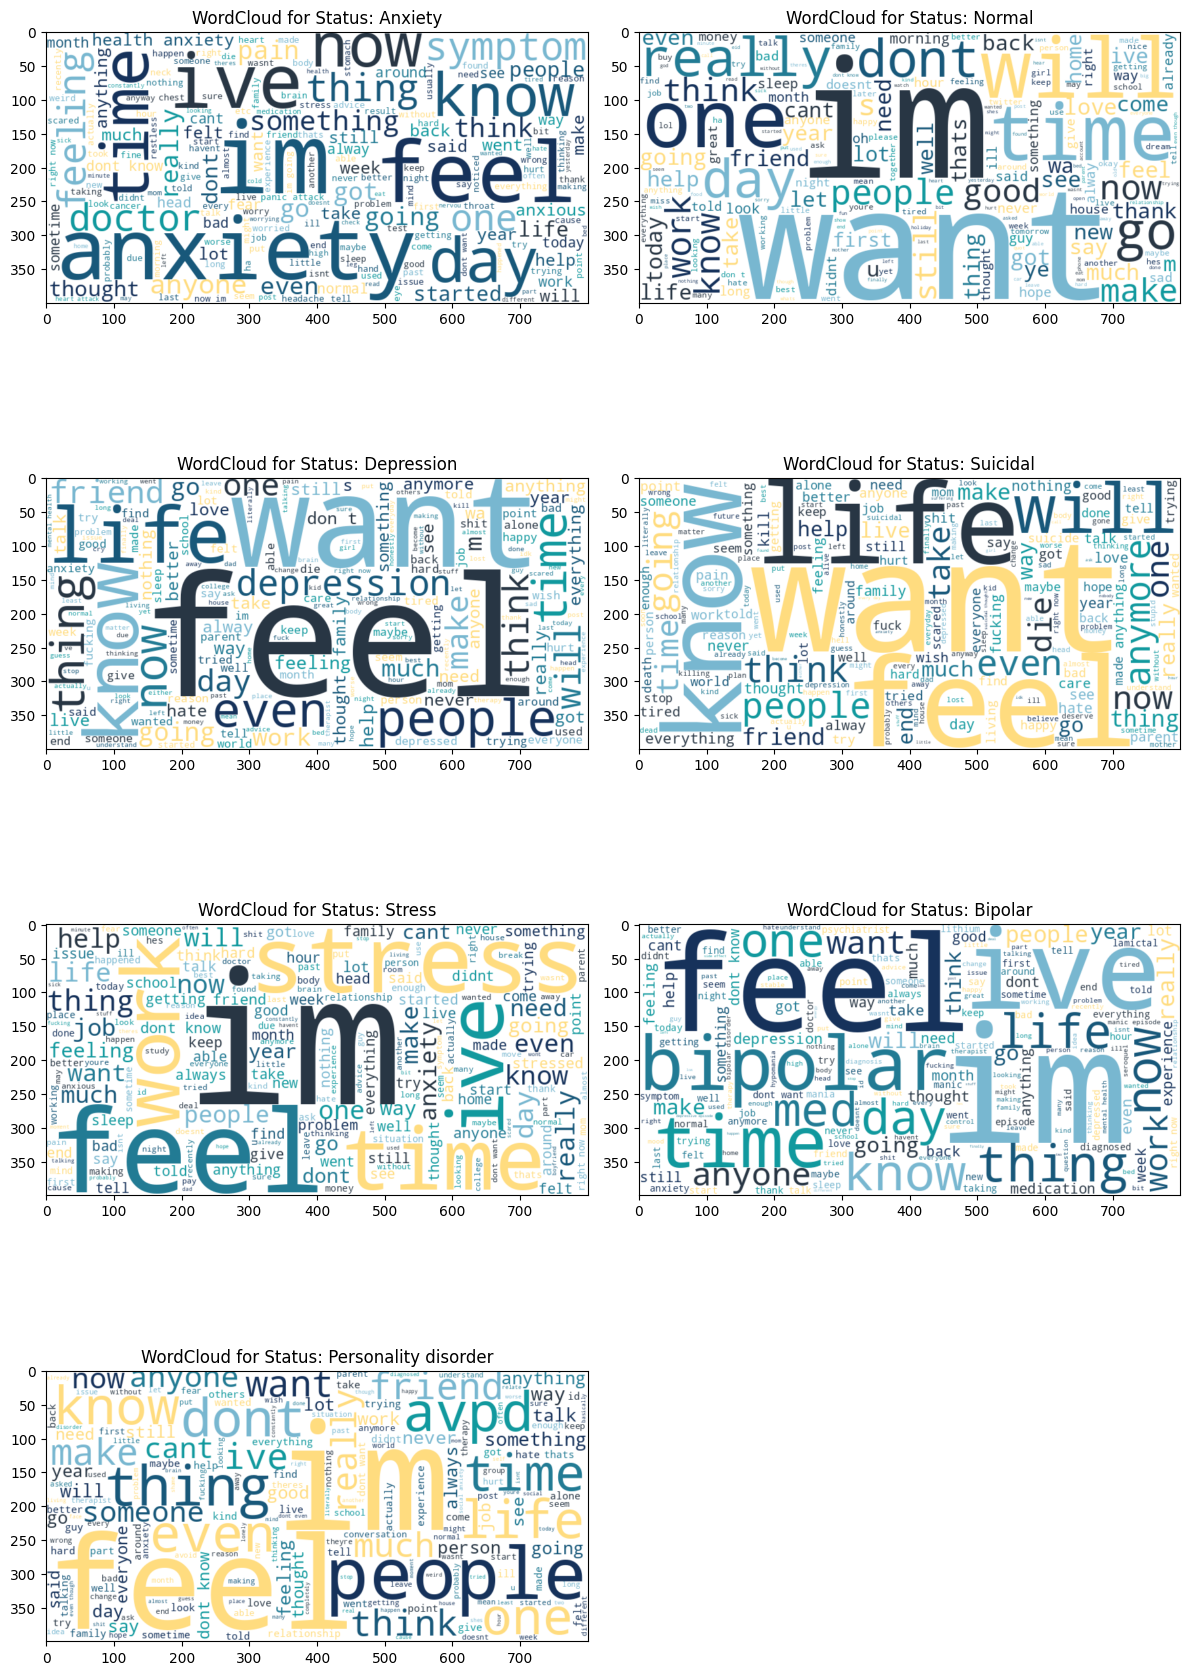

In [24]:
# Get unique categories in 'status'
statuses = df['status'].unique()

plt.figure(figsize=(12, 36))  # Adjust figure size as needed

# Generate and plot the WordCloud for each category
for i, status in enumerate(statuses):
    # Filter the tokens data for the current status
    tokens_data = ' '.join(df[df['status'] == status]['tokens'].dropna().apply(lambda x: ' '.join(x)).tolist())

    # Generate the WordCloud
    wordcloud = WordCloud(width=800, height=400, background_color='white', color_func=color_func).generate(tokens_data)
    
    # Plot the WordCloud in a subplot
    axes = plt.subplot(len(statuses) // 2 + 1, 2, i + 1)  # Adjust number of rows and columns dynamically
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'WordCloud for Status: {status}')
    #plt.axis('off')  # Turn off axes for a cleaner look

# Apply tight layout after generating all subplots
plt.tight_layout()

# Adjust the vertical spacing between subplots (hspace controls vertical space)
plt.subplots_adjust(hspace= -0.8)  # Reduce this value to decrease the vertical distance

plt.show()


# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#4. Data Preprocessing</p>

In [25]:
df.head()

,statement,status,num_of_characters,num_of_sentences,tokens,tokens_stemmed
0,oh my gosh,Anxiety,10.0,1,"[oh, my, gosh]",oh my gosh
1,trouble sleeping confused mind restless heart ...,Anxiety,64.0,2,"[trouble, sleeping, confused, mind, restless, ...",troubl sleep confus mind restless heart all ou...
2,all wrong back off dear forward doubt stay in ...,Anxiety,78.0,2,"[all, wrong, back, off, dear, forward, doubt, ...",all wrong back off dear forward doubt stay in ...
3,ive shifted my focus to something else but im ...,Anxiety,61.0,1,"[ive, shifted, my, focus, to, something, else,...",ive shift my focu to someth els but im still w...
4,im restless and restless its been a month now ...,Anxiety,72.0,2,"[im, restless, and, restless, its, been, a, mo...",im restless and restless it been a month now b...


> Seperate features and labels 

In [26]:
X = df[['tokens_stemmed', 'num_of_characters', 'num_of_sentences']]
y = df['status']

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#4.1 label encoding</p> 

In [27]:
lbl_enc = LabelEncoder()
y = lbl_enc.fit_transform(y.values)

### Split train test

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#4.2 Text to features using TF-IDF vectorizer</p>

In [29]:
# 1. Initialize TF-IDF Vectorizer and fit/transform on the 'tokens' column
vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=50000)
X_train_tfidf = vectorizer.fit_transform(X_train['tokens_stemmed'])
X_test_tfidf = vectorizer.transform(X_test['tokens_stemmed'])

# 2. Extract numerical features
X_train_num = X_train[['num_of_characters', 'num_of_sentences']].values
X_test_num = X_test[['num_of_characters', 'num_of_sentences']].values

# 3. Combine TF-IDF features with numerical features
X_train_combined = hstack([X_train_tfidf, X_train_num])
X_test_combined = hstack([X_test_tfidf, X_test_num])

print('Number of feature words: ', len(vectorizer.get_feature_names_out()))

Number of feature words:  50000


In [30]:
X_train_combined.shape

(42144, 50002)

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#4.3 Resampling</p>  

In [31]:
# Apply Random Over-Sampling on the vectorized data
ros = RandomOverSampler(random_state=101)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_combined, y_train)
X_train_resampled.shape

(91742, 50002)

# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#5. Model Training</p>  

In [32]:
# Initialize XGBoost classifier
xgb_clf = XGBClassifier(learning_rate=0.5, max_depth=7, n_estimators=500, random_state=101)
# Train the classifier on the resampled training data
xgb_clf.fit(X_train_resampled, y_train_resampled)
# Predict the labels on the test data
y_pred = xgb_clf.predict(X_test_combined)

## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#5.1 Accuracy Score</p>  

In [33]:
# Calculate the accuracy score
accuracy = accuracy_score(y_test, y_pred)

# Print the accuracy score
print(f"\nAccuracy: {accuracy}")


Accuracy: 0.8046882414349436


## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#5.2 Confusion Matrix for Predictions</p>  

In [34]:
# Compute the confusion matrix for the predictions
labels = lbl_enc.classes_  # 'lbl_enc.classes_' provides the class labels
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the classification report
print(classification_report(y_test, y_pred, target_names=labels))

                      precision    recall  f1-score   support

             Anxiety       0.83      0.86      0.85       768
             Bipolar       0.89      0.81      0.85       566
          Depression       0.76      0.74      0.75      3050
              Normal       0.92      0.94      0.93      3237
Personality disorder       0.85      0.65      0.74       202
              Stress       0.71      0.73      0.72       530
            Suicidal       0.69      0.71      0.70      2184

            accuracy                           0.80     10537
           macro avg       0.81      0.78      0.79     10537
        weighted avg       0.80      0.80      0.80     10537



## <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">#5.3 Confusion Matrix using Heatmap</p>  

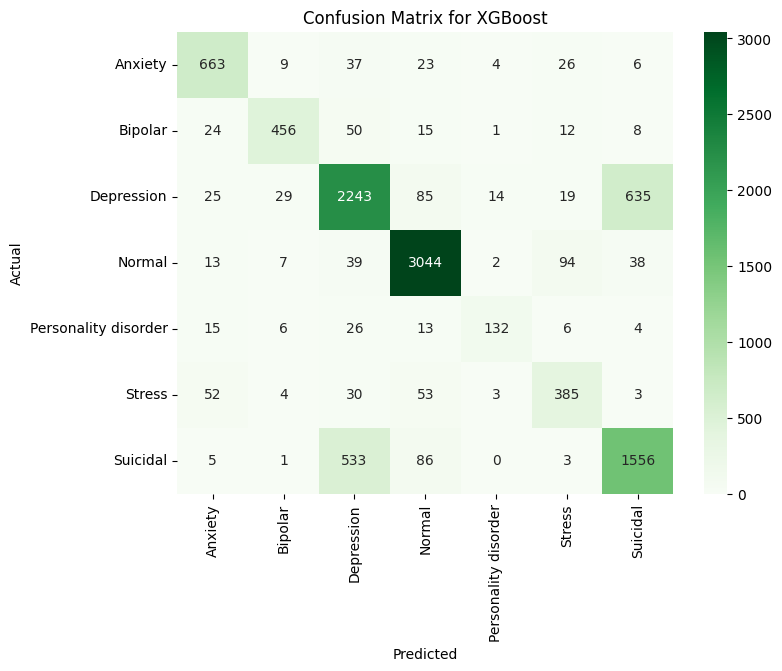

In [35]:
# Plot the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))  # Set the size of the plot
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix for XGBoost')
plt.show()  # Display the heatmap


In [36]:
j.dump(vectorizer,'vecctorizer.pkl')
j.dump(xgb_clf,'model.pkl')

['model.pkl']

# <p style="background-color:#F4A261;font-family:newtimeroman;color:#B43F3F;font-size:150%;text-align:center;border-radius:20px 60px;">Conclusions</p> 

- The preprocessed text data was well-prepared for model training, with special attention given to cleaning, tokenization, and stemming.
- Resampling was necessary to balance the dataset and improve model performance. Without it, the model might have been biased toward the majority class, reducing its ability to detect minority classes (e.g., suicidal expressions).
- The **XGBOOST** classifier was used to train the model, and key metrics like the **accuracy score** and **confusion matrix** helped evaluate its performance.
- The trained model was saved as a `.pkl` file for future use, making it easy to deploy and test on new data.

Overall, the workflow successfully tackled a text classification task focused on identifying depression and suicidal expressions, combining both traditional preprocessing techniques and model evaluation methods.
